## Association rules 

Because we are dealing with sets of artists (since there are sets of artists involved in different events), we decided to try to implement association rules. In this way, we make an attempt to find the hidden patterns between the involvement of specific artists in specific projects. An established rule would supposedly mean that antecedent and consequent should in a way supplement each other, and potentially work in a similar tradition, as very different artists rarely meet on the same ground.

In [1]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

For a start, we load the data and filter the list of announcements to include only events where 20 or more artists have participated. Also, we add up information about different types of events sourced from the data found earlier by institution. This is done to make a more dense selection of artists for future association rules algorithms to give some results.

In [4]:
#       loading the file
with open('data/announcements.json') as file:
    anns = json.load(file)
#       adding the id inside the announcement dict
for id in anns.keys():
    anns[id]['id'] = id
#       creating a dataframe with announcements
anns_list = [value for value in anns.values()]
df = pd.json_normalize(anns_list)
df.set_index('id', inplace=True)
df.drop('title_artists', inplace=True, axis=1)
df.dropna(inplace=True)
df['date'] = df.announcement_date.apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
df['len'] = df.artists.apply(lambda x: len(x))

#       load df with nodes to get venue types
df_nodes = pd.read_csv('data/df_nodes.csv').set_index('subtitle')
for i in df.index:
    try:
        df.loc[i, 'type'] = df_nodes.loc[df.loc[i, 'subtitle'], 'type']
    except:
        df.loc[i, 'type'] = None

#       filter out all the announcements with less than 20 artists
df_filt = df[df.len > 19]
df_filt.tail(5)

,link,title,subtitle,announcement_date,artists,date,len,type
id,,,,,,,,
127497,/announcements/127497/maxxi-re-evolution/,MAXXI RE-EVOLUTION,MAXXI—National Museum of 21st Century Arts,"May 5, 2017","[Armin Linke, Carl Andre, Dominique Perrault, ...",2017-05-05,21,museum
185904,/announcements/185904/issue-42-out-now/,Issue 42 out now,Spike Art Magazine,"January 19, 2015","[Dorothée Dupuis, Georg Baselitz, Harry Burke,...",2015-01-19,20,journal
50452,/announcements/50452/acaw-2016/,ACAW 2016,Asia Contemporary Art Week (ACAW),"October 17, 2016","[Erin Gleeson, Heba Y. Amin, Jennifer Wen Ma, ...",2016-10-17,24,other
209883,/announcements/209883/surface-matters/,Surface Matters,Mutina,"September 19, 2018","[Christopher Williams, Cindy Sherman, Erwan Bo...",2018-09-19,23,other
109694,/announcements/109694/call-for-applications-do...,Call for Applications: Doctoral Studies at the...,University of the Arts Helsinki,"January 5, 2012","[Adrian Piper, Anita Seppä, Boris Groys, DFA, ...",2012-01-05,26,education


In [5]:
print(df_filt.type.value_counts())

type
other        551
education    452
museum       372
journal      293
festival     126
error         98
gallery       74
center        66
Name: count, dtype: int64


Running association rules algorithm by types of institution — the broader sample does not yield any result, so we narrow it down. The min support needs to be really minimal due to the sparse character of the dataset and of the artists between different events. Taking confidence as low as it can get at .2. If min sup <0.05, the script runs for eternity and kernel dies...

In [8]:
#       creating dicts for several assoc rules hyperparameteres
dfs = {}
ohes = {}
bools = {}
freqs = {}
rules = {}
a_lens = {}
a_tops = {}
type_list = [
 'museum',
 'education',
 'center',
 'festival']

min_sups = [.05, .06, .07]

for min_sup in min_sups:
    #       creating more dicts inside for different types
    dfs[min_sup] = {}
    ohes[min_sup] = {}
    bools[min_sup] = {}
    freqs[min_sup] = {}
    rules[min_sup] = {}
    a_lens[min_sup] = {}
    a_tops[min_sup] = {}
    
    for type in type_list:
        #       getting different info about assoc rules in dicts
        dfs[min_sup][type] = df_filt[df_filt.type == type]
        ohes[min_sup][type] = dfs[min_sup][type]['artists'].str.join('|').str.get_dummies()
        bools[min_sup][type] = ohes[min_sup][type].astype(bool)
        freqs[min_sup][type] = apriori(bools[min_sup][type], min_support=min_sup, use_colnames=True)
        try:
            rules[min_sup][type] = association_rules(freqs[min_sup][type], metric="confidence", min_threshold=0.2)
            a_lens[min_sup][type] = len(rules[min_sup][type])
            a_tops[min_sup][type] = rules[min_sup][type].sort_values('confidence', ascending=False).iloc[:5, [0,1,5]]
        except:
            rules[min_sup][type] = None
            a_lens[min_sup][type] = None
            a_tops[min_sup][type] = None


In [9]:
#       cheching minsup=.05 for eductaion group assoc rules
a_tops[0.05]['education']

,antecedents,consequents,confidence
0,(Allan McCollum),(Sam Durant),0.958333
3,(David Humphrey),(Jon Kessler),0.884615
2,(Jon Kessler),(David Humphrey),0.851852
5,(Mark Dion),(Sam Durant),0.700000
4,(Sam Durant),(Mark Dion),0.636364


Text(0.5, 1.0, 'number of generated rules by min support')

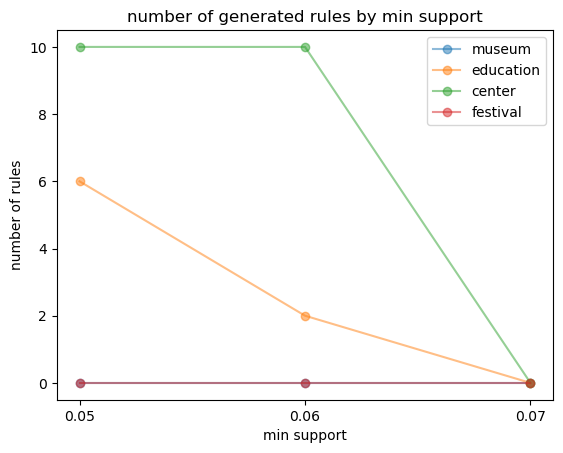

In [10]:
#       showing results
fig, ax = plt.subplots()
for type in type_list:
    ax.plot(min_sups, [a_lens[min_sup][type] for min_sup in min_sups],
            label=type, marker='o', alpha=.5)

ax.legend()
ax.set_xticks(min_sups)
ax.set_xlabel('min support')
ax.set_ylabel('number of rules')
ax.set_title('number of generated rules by min support')

These by-announcement association rules were not very successful — although there are some rules, the support is quite low, and the rules might just be by chance. To try something different, we decided to run the institution-wide association rules — in this case itis testet which artists tend to collaborate with specific institutions and not within the specific event. This gives us a chance to think about more institutionalist perspective of the art analysis, and see som epaterns of what artists institutions often choose to represent with other mates. First, we create the new database. In this way we also avoid some very 'boring' association rules, for example, in galleries or journals, where they mention the same people in every announcement (that is why these groups were excluded of the group analysis behind — as they worked awfully). Here the script works better, and we can explore different options of hyperparameters.

In [12]:
#       same load
with open('data/announcements.json') as file:
    anns = json.load(file)

for id in anns.keys():
    anns[id]['id'] = id
anns_list = [value for value in anns.values()]
df = pd.json_normalize(anns_list)
df.set_index('id', inplace=True)
df.drop('title_artists', inplace=True, axis=1)
df.dropna(inplace=True)
df['date'] = df.announcement_date.apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
df['len'] = df.artists.apply(lambda x: len(x))

df_nodes = pd.read_csv('data/df_nodes.csv').set_index('subtitle')
for i in df.index:
    try:
        df.loc[i, 'type'] = df_nodes.loc[df.loc[i, 'subtitle'], 'type']
    except:
        df.loc[i, 'type'] = None

#       create a differnt df, groupby institution, all the artists that ever were there
df2 = df[['subtitle','artists']].groupby('subtitle').sum()
df2['lenlist'] = df2.artists.apply(lambda x: len(x))
df2['set'] = df2.artists.apply(lambda x: set(x))
df2['lenset'] = df2.set.apply(lambda x: len(x))
df2['setlist'] = df2.set.apply(lambda x: list(x))
df2['differ'] = df2.lenlist-df2.lenset
df2.differ.value_counts()
#       filter for artist number > 100
df3 = df2[df2.lenset > 100]
df3.head(3)

,artists,lenlist,set,lenset,setlist,differ
subtitle,,,,,,
49 Nord 6 Est – Frac Lorraine,"[ADAGP, Betye Saar, Chanel, ICA Miami, Metz, É...",150,"{Ian Wilson, Jeremy Deller, Lara Almarcegui, C...",131,"[Ian Wilson, Jeremy Deller, Lara Almarcegui, C...",19
ABC Art Berlin Contemporary,"[A Kassen, Alexandra Bachzetsis, Anahita Razmi...",275,"{Anahita Razmi, Heinrich Dunst, Gino de Domini...",228,"[Anahita Razmi, Heinrich Dunst, Gino de Domini...",47
ARCOmadrid,"[ARCOmadrid, Bouchra Khalili, David Zwirner, E...",311,"{Brooke Davis Anderson, Catalina Lozano, Isabe...",173,"[Brooke Davis Anderson, Catalina Lozano, Isabe...",138


In [13]:
#       prepare data for assoc rules
onehot = df3['setlist'].str.join('|').str.get_dummies()
bools = onehot.astype(bool)

#       now store only number of assoc rules and top-5 rules
lens = {}
tops = {}

#       hyperparameters
thrs = np.linspace(.1,.9,9)
sups = np.linspace(.03,.13,11)

#       running assoc rules, filling dicts
for thr in thrs:
    lens[thr] = {}
    tops[thr] = {}
    for sup in sups:
        frequent_itemsets = apriori(bools, min_support=sup, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=thr)
        lens[thr][sup] = len(rules)
        tops[thr][sup] = rules[['antecedents', 'consequents', 'confidence']].sort_values('confidence', ascending=False)[:5]

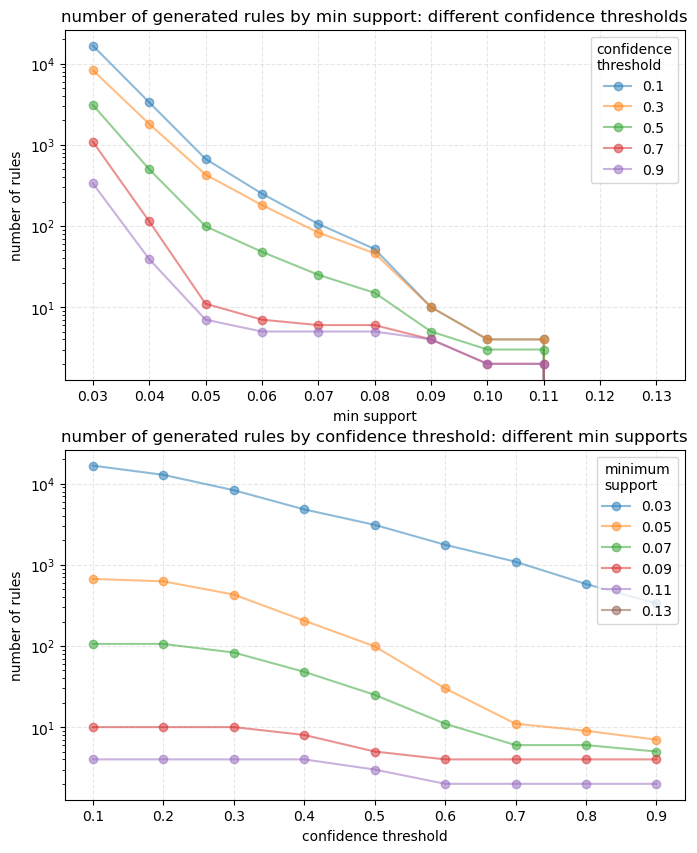

In [14]:
#       visualising results

fig, ax = plt.subplots(2,1,figsize=(8,10))
for thr in thrs[::2]:
    ax[0].plot(lens[thr].keys(), lens[thr].values(), label=f'{thr:.1f}', marker='o', alpha=.5)
ax[0].set_xticks(sups)
ax[0].set_yscale('log')
ax[0].set_xlabel('min support')
ax[0].set_ylabel('number of rules')
ax[0].set_title('number of generated rules by min support: different confidence thresholds')
ax[0].grid(ls='--', alpha=.3)
leg0 = ax[0].legend()
leg0.set_title('confidence\nthreshold')

for sup in sups[::2]:
    ax[1].plot(thrs, [lens[thr][sup] for thr in thrs], label=f'{sup:.2f}', marker='o', alpha=.5)
ax[1].set_xticks(thrs)
ax[1].set_yscale('log')
ax[1].set_xlabel('confidence threshold')
ax[1].set_ylabel('number of rules')
ax[1].set_title('number of generated rules by confidence threshold: different min supports')
ax[1].grid(ls='--', alpha=.3)
leg0 = ax[1].legend()
leg0.set_title('minimum\nsupport')

In [15]:
#       showing top assoc rules for different min support
for sup in sups[::2]:
    print(f'\nFor minimum support of {sup:.2f} the top rules are:\n{tops[0.1][sup]}')


For minimum support of 0.03 the top rules are:
                                antecedents           consequents  confidence
15580  (Lawrence Abu Hamdan, Renate Lorenz)      (Pauline Boudry)         1.0
14444       (Sophia Al-Maria, Martine Syms)  (Hans Ulrich Obrist)         1.0
11872          (Aria Dean, Cameron Rowland)        (Martine Syms)         1.0
8477                         (Lizzie Fitch)      (Ryan Trecartin)         1.0
11906                (Ian Cheng, Aria Dean)  (Hans Ulrich Obrist)         1.0

For minimum support of 0.05 the top rules are:
                                 antecedents          consequents  confidence
486                      (Joana Hadjithomas)     (Khalil Joreige)      1.0000
664  (Joana Hadjithomas, Hans Ulrich Obrist)     (Khalil Joreige)      1.0000
148                            (Basel Abbas)  (Ruanne Abou-Rahme)      1.0000
614                         (Pauline Boudry)      (Renate Lorenz)      0.9375
487                         (Khalil Joreige)  

In this way, institution-wide association rules work much better and deliver interesting results that shed the light on how institutions choose the artist to work with.